In [79]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.algorithms.optimizers import GradientDescent, SPSA, QNSPSA
from qiskit.algorithms.gradients import LinCombQFI, LinCombEstimatorGradient
from qiskit.primitives import Estimator, Sampler
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow import PauliSumOp

### Landscape

In [2]:
operator = PauliSumOp.from_list([
    ("Z", 1),
#     ("ZI", 1),
])

In [3]:
ansatz = QAOAAnsatz(operator)

In [4]:
x1 = Parameter("x1")
x2 = Parameter("x2")
ansatz = QuantumCircuit(1)
ansatz.rx(x1, 0)
ansatz.ry(x2, 0)

In [5]:
estimator = Estimator()

In [6]:
def energy(theta, scaling=1):
    theta = scaling * np.asarray(theta)
    return estimator.run(ansatz, operator, theta).result().values[0].real

In [7]:
x = np.linspace(0.5, 4, num=100)
y = np.linspace(-1, 4, num=100)
X, Y = np.meshgrid(x, y)

values = [[energy([x_i, y_j]) for x_i in x] for y_j in y]

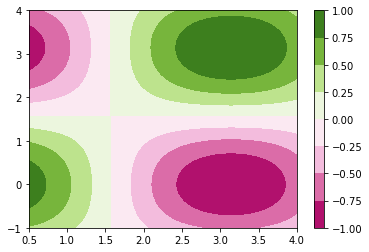

In [8]:
plt.contourf(X, Y, values, cmap="PiYG")
plt.colorbar()

In [9]:
x = np.linspace(1.9, 2.8, num=100)
y = np.linspace(1.3, 2.5, num=100)
X_x5, Y_x5 = np.meshgrid(x, y)
values_x5 = [[energy([x_i, y_j], scaling=5) for x_i in x] for y_j in y]

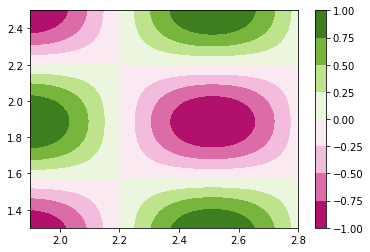

In [10]:
plt.contourf(X_x5, Y_x5, values_x5, cmap="PiYG")
plt.colorbar()

## Optimizers

In [11]:
x0 = np.array([2.2, 2])

In [12]:
def plot_traj(traj, *args, **kwargs):
    x = [x[0] for x in traj]
    y = [x[1] for x in traj]
    plt.plot(x, y, *args, **kwargs)

### Gradient descent

In [28]:
lcu = LinCombEstimatorGradient(estimator)

def gradient(theta):
    return lcu.run([ansatz.copy()], [operator], [theta]).result().gradients[0]

In [29]:
gd_traj = [x0]

def store_trajectory(*args):
    gd_traj.append(args[1])
    
gd = GradientDescent(maxiter=10, learning_rate=0.5, callback=store_trajectory)
result = gd.minimize(energy, x0, jac=gradient)

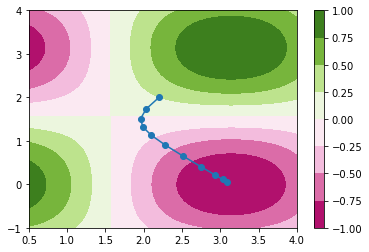

In [31]:
plot_traj(gd_traj, "o-", color="tab:blue")
plt.contourf(X, Y, values, cmap="PiYG")
plt.colorbar()

### Natural gradients

In [16]:
ansatz.draw()

┌────────┐┌────────┐
q: ┤ Rx(x1) ├┤ Ry(x2) ├
   └────────┘└────────┘

In [22]:
lcu = LinCombEstimatorGradient(estimator)
qfi = LinCombQFI(estimator)

def natural_gradient(theta):
    qgt = qfi.run([ansatz], [theta]).result().qfis[0] / 4
    grad = lcu.run([ansatz], [operator], [theta]).result().gradients[0]
    return np.linalg.solve(qgt, grad)

In [42]:
ngd_traj = [x0]

def store_trajectory(*args):
    ngd_traj.append(args[1])
    
ngd = GradientDescent(maxiter=10, learning_rate=0.1, callback=store_trajectory)
result = ngd.minimize(energy, x0, jac=natural_gradient)

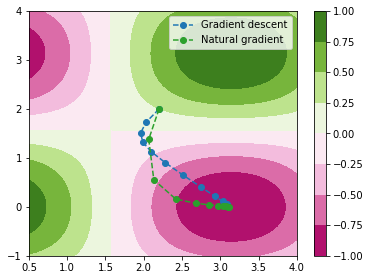

In [70]:
plt.figure(figsize=(6, 4.5))
plot_traj(gd_traj, ls="--", marker="o", color="tab:blue", label="Gradient descent")
plot_traj(ngd_traj, ls="--", marker="o", color="tab:green", label="Natural gradient")
plt.contourf(X, Y, values, cmap="PiYG")
plt.legend(loc="best")
plt.colorbar()
plt.savefig("x1.pdf")

### SPSA

In [44]:
spsa_traj = [x0]

def store_trajectory(*args):
    spsa_traj.append(args[1])
    
spsa = SPSA(maxiter=10, learning_rate=0.5, perturbation=0.01, callback=store_trajectory)
result = spsa.minimize(energy, x0)

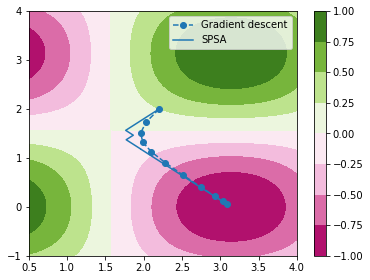

In [71]:
plt.figure(figsize=(6, 4.5))
plot_traj(gd_traj, ls="--", marker="o", color="tab:blue", label="Gradient descent")
plot_traj(spsa_traj, ls="-", color="tab:blue", label="SPSA")
plt.contourf(X, Y, values, cmap="PiYG")
plt.legend(loc="best")
plt.colorbar()
plt.savefig("x1_spsa.pdf")

In [46]:
spsa5_traj = [x0]

def store_trajectory(*args):
    spsa5_traj.append(args[1])
    
spsa = SPSA(maxiter=10, learning_rate=0.5, perturbation=0.01, callback=store_trajectory)
result = spsa.minimize(lambda theta: energy(theta, scaling=5), x0)

In [ ]:
plot_traj(spsa5_traj, "o-")
plt.contourf(X_x5, Y_x5, values_x5, cmap="PiYG")
plt.colorbar()

### QN-SPSA

In [47]:
sampler = Sampler()
fidelity = QNSPSA.get_fidelity(ansatz, sampler=sampler)

In [77]:
qnspsa_traj = [x0]

def store_trajectory(*args):
    qnspsa_traj.append(args[1])
    
qnspsa = QNSPSA(fidelity, resamplings=2, maxiter=20, learning_rate=0.1, perturbation=0.01, callback=store_trajectory)
result = qnspsa.minimize(energy, x0)

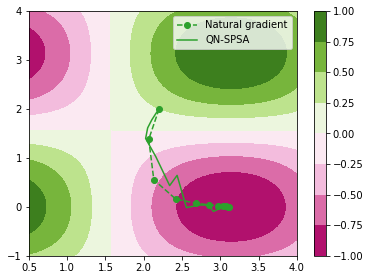

In [78]:
plt.figure(figsize=(6, 4.5))
plot_traj(ngd_traj, ls="--", marker="o", color="tab:green", label="Natural gradient")
plot_traj(qnspsa_traj, ls="-", color="tab:green", label="QN-SPSA")
plt.contourf(X, Y, values, cmap="PiYG")
plt.legend(loc="best")
plt.colorbar()
plt.savefig("x1_qnspsa.pdf")

In [ ]:
qnspsa5_traj = [x0]

def store_trajectory(*args):
    qnspsa5_traj.append(args[1])
    
qnspsa = QNSPSA(fidelity, resamplings=10, maxiter=10, learning_rate=0.1, perturbation=0.01, callback=store_trajectory)
result = qnspsa.minimize(lambda theta: energy(theta, scaling=5), x0)

In [ ]:
plot_traj(qnspsa5_traj, "o-")
plt.contourf(X_x5, Y_x5, values_x5, cmap="PiYG")
plt.colorbar()

## Pennylane example

In [82]:
params = ParameterVector("x", 4)
circuit = QuantumCircuit(3)
circuit.ry(np.pi / 4, 0)
circuit.ry(np.pi / 3, 1)
circuit.ry(np.pi / 7, 2)

# V0(theta0, theta1): Parametrized layer 0
circuit.rz(params[0], 0)
circuit.rz(params[1], 1)

# W1: non-parametrized gates
circuit.cx(0, 1)
circuit.cx(1, 2)

# V_1(theta2, theta3): Parametrized layer 1
circuit.ry(params[2], 1)
circuit.rx(params[3], 2)

# W2: non-parametrized gates
circuit.cx(0, 1)
circuit.cx(1, 2)

observable = PauliSumOp.from_list([("IIY", 1)])

# execution parameters
initial_point = np.array([0.432, -0.123, 0.543, 0.233])

In [83]:
def loss(theta):
    return estimator.run(circuit, observable, theta).result().values[0].real

Gradient descent:

In [84]:
lcu = LinCombEstimatorGradient(estimator)

def gradient(theta):
    return lcu.run([circuit], [observable], [theta]).result().gradients[0]

In [88]:
gd_losses = []

def store_losses(*args):
    gd_losses.append(args[2])
    
gd = GradientDescent(maxiter=300, learning_rate=0.01, callback=store_losses)
result = gd.minimize(loss, initial_point, jac=gradient)

In [85]:
lcu = LinCombEstimatorGradient(estimator)
qfi = LinCombQFI(estimator)

def natural_gradient(theta):
    qgt = qfi.run([circuit], [theta]).result().qfis[0] / 4
    grad = lcu.run([circuit], [observable], [theta]).result().gradients[0]
    return np.linalg.solve(qgt, grad)

In [89]:
ngd_losses = []

def store_losses(*args):
    ngd_losses.append(args[2])
        
gd = GradientDescent(maxiter=300, learning_rate=0.01, callback=store_losses)
result = gd.minimize(loss, initial_point, jac=natural_gradient)

In [90]:
spsa_losses = []

def store_losses(*args):
    spsa_losses.append(args[2])
    
spsa = SPSA(maxiter=300, learning_rate=0.01, perturbation=0.01, callback=store_losses)
result = spsa.minimize(loss, initial_point)

In [86]:
sampler = Sampler()
fidelity = QNSPSA.get_fidelity(circuit, sampler=sampler)

In [105]:
qnspsa_losses = []

def store_losses(*args):
    qnspsa_losses.append(args[2])
    
qnspsa = QNSPSA(fidelity, resamplings=1, maxiter=300, learning_rate=0.01, perturbation=0.01, callback=store_losses)
result = qnspsa.minimize(loss, initial_point)

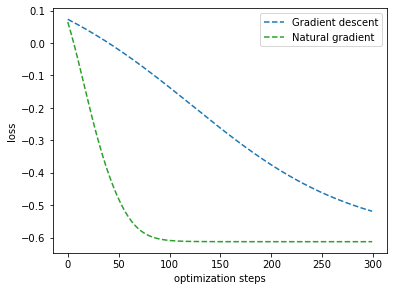

In [121]:
plt.figure(figsize=(6, 4.5))
plt.plot(gd_losses, color="tab:blue", ls="--", label="Gradient descent")
plt.plot(ngd_losses, color="tab:green", ls="--", label="Natural gradient")
plt.xlabel("optimization steps")
plt.ylabel("loss")
plt.legend(loc="best")
plt.savefig("conv_gd.pdf")

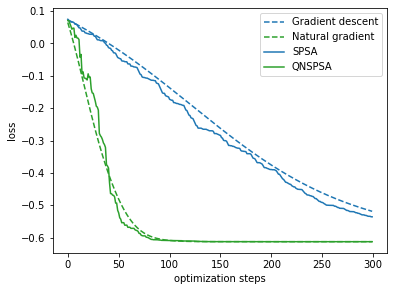

In [120]:
plt.figure(figsize=(6, 4.5))
plt.plot(gd_losses, color="tab:blue", ls="--", label="Gradient descent")
plt.plot(ngd_losses, color="tab:green", ls="--", label="Natural gradient")
plt.plot(spsa_losses, color="tab:blue", label="SPSA")
plt.plot(qnspsa_losses, color="tab:green", label="QNSPSA")

plt.xlabel("optimization steps")
plt.ylabel("loss")
plt.legend(loc="best")
plt.savefig("conv_all.pdf")

In [108]:
d = circuit.num_parameters
m = 300
gd_fevals = d * np.arange(1, m + 1)
ngd_fevals = d * (d + 1) / 2 * np.arange(1, m + 1)
spsa_fevals = 2 * np.arange(1, m + 1)
qnspsa_fevals = 7 * np.arange(1, m + 1)

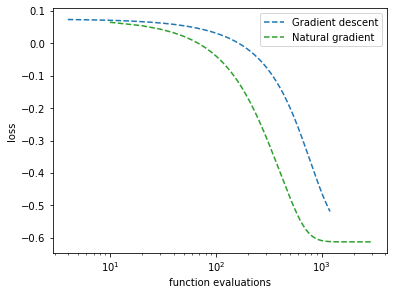

In [119]:
plt.figure(figsize=(6, 4.5))
plt.semilogx()
plt.plot(gd_fevals, gd_losses, color="tab:blue", ls="--", label="Gradient descent")
plt.plot(ngd_fevals, ngd_losses, color="tab:green", ls="--", label="Natural gradient")

plt.xlabel("function evaluations")
plt.ylabel("loss")
plt.legend(loc="best")
plt.savefig("fevals_gd.pdf")

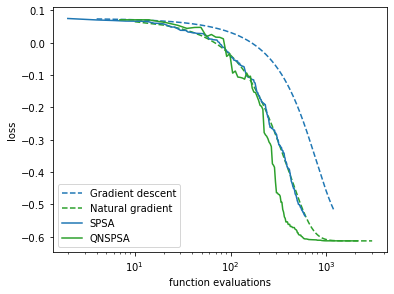

In [118]:
plt.figure(figsize=(6, 4.5))
plt.semilogx()
plt.plot(gd_fevals, gd_losses, color="tab:blue", ls="--", label="Gradient descent")
plt.plot(ngd_fevals, ngd_losses, color="tab:green", ls="--", label="Natural gradient")
plt.plot(spsa_fevals, spsa_losses, color="tab:blue", label="SPSA")
plt.plot(qnspsa_fevals, qnspsa_losses, color="tab:green", label="QNSPSA")

plt.xlabel("function evaluations")
plt.ylabel("loss")
plt.legend(loc="best")
plt.savefig("fevals_all.pdf")